In [1]:
%pylab inline

import os
import scipy.io
import numpy as np
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
###################################### LOADING DATA ##############################

### Create a dictionary that contains all the dictiories within each dataset (workspace) we want to load ###

#Go to the data directory
dataDir = "C:/Liliana/DATA_CNN_networks/"

Load_Data = {}  
for i in range(0, len(os.listdir( dataDir ))):  
    Load_Data[i] = {}  #Dictionary for a single workspace

    

### lOAD THE DATA STORING THEM IN A DICTIONARY ###

i = 0
for file in os.listdir( dataDir ):
    Load_Data[i]['File'] =  scipy.io.loadmat( dataDir+file )
    i = i+1
    
#print(All_Data[0]['File']['decisionlist'])
#print(All_Data[1]['File']['RESULTS']['STATISTICS'][0,0]['TotalNumCells'][0])
#print(All_Data[1]['File']['RAWDATA'][0,0]['files'][0,0]['coords_x'].astype(double))
#print(All_Data[1]['File']['RAWDATA'][0,0]['files'][0,0][0]['intensity'][0])  #intensity curve for first cell
#print(All_Data[1]['File']['decisionlist'])  #decision list


#### Define another dictionary for storing intensity curves and classes ### 
#From each dataset, the intensity curve and classes are extracted and stored in another dictionary

DATA = {}
N_of_file =len(os.listdir( dataDir ))
for i in range(0, N_of_file):
        DATA[i] = {}



#### Fill the dictionary ###

Ncell_classified = 200 #Number of classified cells per dataset

for i in range(0, N_of_file):
    #Decision array for each dataset
    DATA[i]['decision'] = Load_Data[i]['File']['decisionlist']
    
    #Size of the matrix to store intensity values
    NumofData = len(Load_Data[i]['File']['RAWDATA'][0,0]['files'][0,0][0]['intensity'])
    Int_curve_len = len(Load_Data[4]['File']['RAWDATA'][0,0]['files'][0,0][0]['intensity'][0][0])
    
    #Empty matrix to store all the intensity values of all the cells
    DATA[i]['intensity'] = np.zeros((Ncell_classified,  Int_curve_len ))
    
    for k in range(0,Ncell_classified): #Only the first 200 were classified
        DATA[i]['intensity'][k,:] = Load_Data[i]['File']['RAWDATA'][0,0]['files'][0,0][0]['intensity'][k][0,0:900] #copy the first 900 values
    
    


In [3]:
### Classes array: contain values from all the data ###

Classes=[]
for i in range( 0, N_of_file ):
    Classes = np.append(Classes , DATA[i]['decision']).astype(int)

### Intensities matrix: contain values from all the data    
NTot_Data = N_of_file*Ncell_classified

Intensity = np.zeros((0, DATA[0]['intensity'].shape[1]))
for i in range( 0, N_of_file ):
    Intensity = np.append(Intensity, DATA[i]['intensity'][:,:], axis=0)
    
    
print(Classes.shape)

(1000,)


In [4]:
### Elimate intensity profiles with NaN values and corresponding classes ###

nan_indices = np.where(np.isnan(Intensity))

Intensity = np.delete(Intensity,nan_indices[0], axis = 0)
Classes = np.delete(Classes,nan_indices[0], axis = 0)

print(Intensity.shape)
print(Classes.shape)

#Redefine the total number of data
total = len(Intensity)

(990, 900)
(990,)


In [5]:
### Downsampling ###
data1 = Intensity[:,0:896]
print(data1.shape)

step = 7
data_downsampl = data1[:,::step]
print('data shape', data_downsampl.shape)

#Redefine len of the Intensity curves:
Int_profile_len = len(data_downsampl[0])
print(Int_profile_len)
print(data_downsampl.shape)

(990, 896)
data shape (990, 128)
128
(990, 128)


In [ ]:

for i in range(len(Classes)):
    if Classes[i] == 22:
        print(i)
    elif Classes[i] == 23:
        print(i)


In [6]:
### Distribute all values randomly ###

print('total',total)
randseq = np.random.choice(np.arange(0,total),total,replace=False)

print(randseq.shape)
#Data randomly organized
data_downsampl = data_downsampl[randseq,:]
Classes = Classes[randseq]

print(Classes.shape)
print(data_downsampl.shape)

total 990
(990,)
(990,)
(990, 128)


In [7]:
######################### load file - training data ####################

train_dt = data_downsampl[0:800,:]
train_cl = Classes[0:800]

X = train_dt  
y = train_cl 


print(train_dt.shape)
N_train_cell = len(train_dt)
print('N of training data', N_train_cell)
print('len intensity', Int_profile_len)
# process the data to fit in a keras CNN properly
# input data needs to be (N, C, X, Y) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size


X = X.reshape((N_train_cell, Int_profile_len,1, 1))
y = np_utils.to_categorical(y)

print(y)


(800, 128)
N of training data 800
len intensity 128
[[ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]]


In [12]:
######################### load file - testing data ####################

#Define variables 
N_test_cell = total - N_train_cell
print('N_test_cell =', N_test_cell)

#Matrix for intensity values
test_dt = np.zeros((N_test_cell,Int_profile_len))

#Use as testing data the last N_test_cell values within the total 
test_dt[:,:]= data_downsampl[N_train_cell:total]

#Same process for the associated classes
test_cl = Classes[N_train_cell:total]

print(test_dt.shape)
print(test_cl.shape)


N_test_cell = 190
(190, 128)
(190,)


In [13]:
# define a CNN
# see http://keras.io for API reference

cnn = Sequential()
cnn.add(Convolution2D(64, (3, 1),activation="relu",input_shape=(Int_profile_len,1, 1),padding="same"))
cnn.add(Convolution2D(64, (3, 1), activation="relu", padding="same"))
cnn.add(MaxPooling2D(pool_size=(2,1)))

#border_mode = same => output size is the same of input size. The filter does not go outside the bounds of the input
#ReLU => thresholding at zero. All the negative values will be = 0, values bigger than zero will mantain the same value.
cnn.add(Convolution2D(128, (3, 1), activation="relu", padding="same"))
cnn.add(Convolution2D(128, (3, 1), activation="relu", padding="same"))
cnn.add(Convolution2D(128, (3, 1), activation="relu", padding="same"))
cnn.add(MaxPooling2D(pool_size=(2,1)))
    
cnn.add(Convolution2D(256, (3, 1), activation="relu", padding="same"))
cnn.add(Convolution2D(256, (3, 1), activation="relu", padding="same"))
cnn.add(Convolution2D(256, (3, 1), activation="relu", padding="same"))
cnn.add(MaxPooling2D(pool_size=(2,1)))
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5)) 
cnn.add(Dense(6, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))
#default parameters coming from the paper: https://arxiv.org/abs/1412.6980v8

In [14]:
for i in range(5):
    print(i)
    # train
    cnn.fit(X, y, epochs=20, verbose = 2)
    #Evaluation code which makes prediction
    out = cnn.predict(test_dt.reshape((N_test_cell, Int_profile_len,1, 1)))

0
Epoch 1/20
6s - loss: 1.5267
Epoch 2/20
5s - loss: 1.0856
Epoch 3/20
5s - loss: 1.0086
Epoch 4/20
5s - loss: 0.9589
Epoch 5/20
6s - loss: 0.8813
Epoch 6/20
6s - loss: 0.7759
Epoch 7/20
6s - loss: 0.7060
Epoch 8/20
6s - loss: 0.5845
Epoch 9/20
6s - loss: 0.5009
Epoch 10/20
6s - loss: 0.4773
Epoch 11/20
6s - loss: 0.4368
Epoch 12/20
6s - loss: 0.4059
Epoch 13/20
6s - loss: 0.3880
Epoch 14/20
6s - loss: 0.3601
Epoch 15/20
6s - loss: 0.3770
Epoch 16/20
6s - loss: 0.3384
Epoch 17/20
6s - loss: 0.3442
Epoch 18/20
6s - loss: 0.3240
Epoch 19/20
6s - loss: 0.3060
Epoch 20/20
6s - loss: 0.3124
1
Epoch 1/20
6s - loss: 0.2990
Epoch 2/20
6s - loss: 0.2954
Epoch 3/20
6s - loss: 0.2877
Epoch 4/20
6s - loss: 0.2675
Epoch 5/20
6s - loss: 0.2679
Epoch 6/20
6s - loss: 0.2737
Epoch 7/20
6s - loss: 0.2642
Epoch 8/20
6s - loss: 0.2511
Epoch 9/20
6s - loss: 0.2387
Epoch 10/20
6s - loss: 0.2391
Epoch 11/20
6s - loss: 0.2409
Epoch 12/20
6s - loss: 0.2405
Epoch 13/20
6s - loss: 0.2388
Epoch 14/20
6s - loss: 0

In [26]:
%pylab inline
print(out[0])
print(test_cl[0])

print(float(np.sum(np.argmax(out,1)==test_cl))/float(test_cl.shape[0])*100.0)

Populating the interactive namespace from numpy and matplotlib
[  2.15524372e-22   9.99993563e-01   6.38275378e-06   9.76214297e-23
   4.15435993e-28   9.04088612e-14]
1
91.57894736842105


C:\Users\Liliana\Anaconda2\envs\myenv2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['legend']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


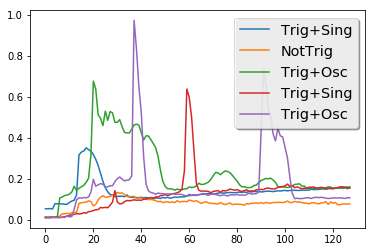

In [25]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
for i in range(10,15):
    if test_cl[i] == 1:
        ax.plot(test_dt[i,:], label='Trig+Sing')
    if test_cl[i] == 2:
        ax.plot(test_dt[i,:], label='Trig+Osc')
    if test_cl[i] == 3:
        ax.plot(test_dt[i,:], label='Trig+Sust')
    if test_cl[i] == 4:
        ax.plot(test_dt[i,:], label='NotTrig')
    if test_cl[i] == 5:
        ax.plot(test_dt[i,:], label='Not Sure')
    legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')